In [ ]:
data = get_coin_data('BTC/USDT', '1h', start_date=Timestamp('2021-01-01'))
data

,Open,High,Low,Close,Volume
Timestamp,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803
...,...,...,...,...,...
2023-12-12 06:00:00,41566.00,41697.07,41401.92,41695.04,1585.873080
2023-12-12 07:00:00,41695.05,42068.91,41678.98,41916.27,2723.393660
2023-12-12 08:00:00,41916.26,42104.12,41778.06,42036.86,2040.349830


In [ ]:
# check for missing data
print(data.isnull().sum())

# missing dates
idx = pd.date_range(start=data.index[0], end=data.index[-1], freq='1h')
idx.rename('Timestamp', inplace=True)
data = data.reindex(idx)
print(data.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Open      14
High      14
Low       14
Close     14
Volume    14
dtype: int64


In [ ]:
data.dropna(inplace=True)
print(data.isnull().sum())
print(data.shape)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
(25797, 5)


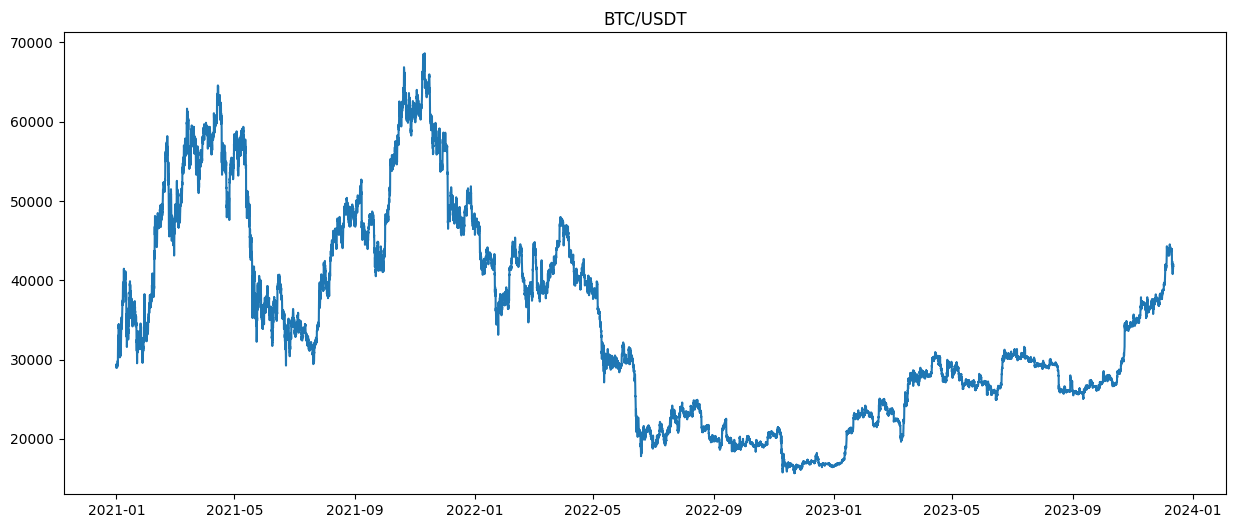

In [ ]:
# plot the data
plt.figure(figsize=(15,6))
plt.plot(data['Close'])
plt.title('BTC/USDT')
plt.show()

Its not great that we have missing data, but a total of 14 missing values out of 25_000+ is not too bad. We can just drop these rows.

# TODO: 
- pre-process the data (ie: normalize)
- split into train and test sets
- add other indicators

# Build gym 🏋💪🤖💪

In [ ]:
# help(gym.make)
# print(gym.envs.registry.keys())
env = gym.make('stocks-v0', df=data, frame_bound=(20,200), window_size=20)

info {'total_reward': 7819.806640625, 'total_profit': 0.6493357288082583, 'position': <Positions.Short: 0>}


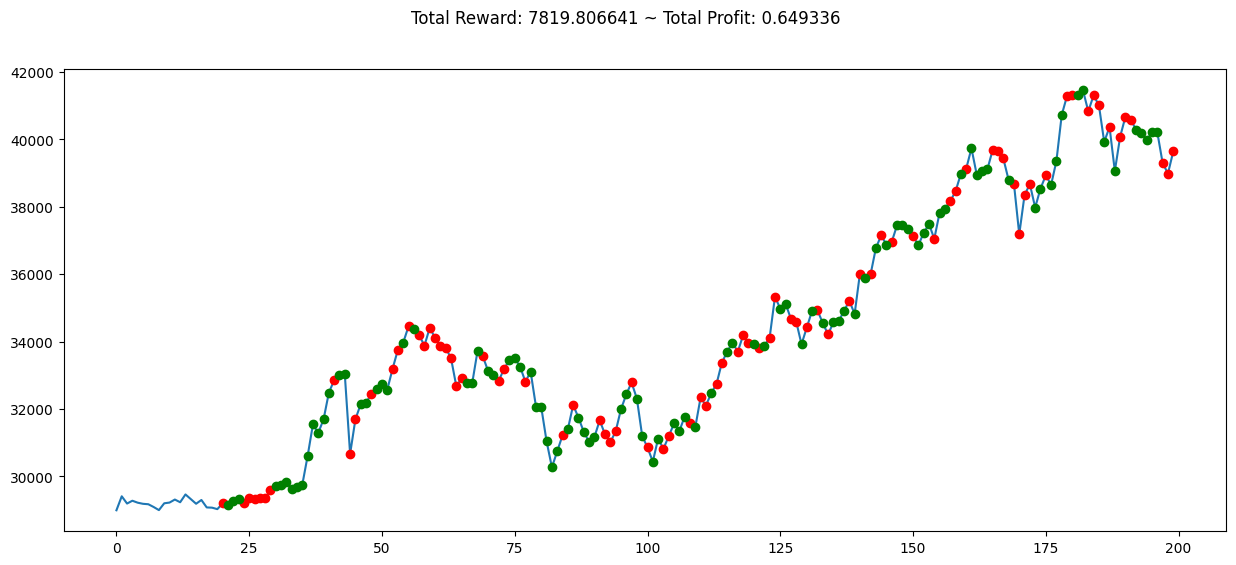

In [ ]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, truncated, info = env.step(action)
    if done or truncated:
        print("info", info)
        break

plt.figure(figsize=(15,6), facecolor='white')
plt.cla()
env.unwrapped.render_all()
plt.show()

# Train agent

In [ ]:
env_maker = lambda: gym.make('stocks-v0', df=data,  frame_bound=(10,1000), window_size=10)
env = DummyVecEnv([env_maker])

Notes:
- A2C is on-policy, does not use buffer, not very stable
- better to use some off-policy algorithm like DQN or DDPG


DQN is probably a better choice. It is off-policy, it can use a replay buffer, soft updates, double DQN, dueling DQN, etc. It is slower to train, but it is more stable.

In [ ]:
# TODO: consider LstmPolicy
# TODO: double DQN
# TODO: tune hypers
model = DQN('MlpPolicy', env, learning_starts=100, verbose=1)

eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=25,
                             n_eval_episodes=1,
                             deterministic=True, render=False)
model.learn(total_timesteps=1e3, callback=eval_callback)

Using cuda device


/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/bitcoinbot/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25, episode_reward=0.00 +/- 0.00
Episode length: 989.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 989      |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.772    |
| time/               |          |
|    total_timesteps  | 25       |
----------------------------------
New best mean reward!
Eval num_timesteps=50, episode_reward=0.00 +/- 0.00
Episode length: 989.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 989      |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.534    |
| time/               |          |
|    total_timesteps  | 50       |
----------------------------------
Eval num_timesteps=75, episode_reward=0.00 +/- 0.00
Episode length: 989.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 98

KeyboardInterrupt: 

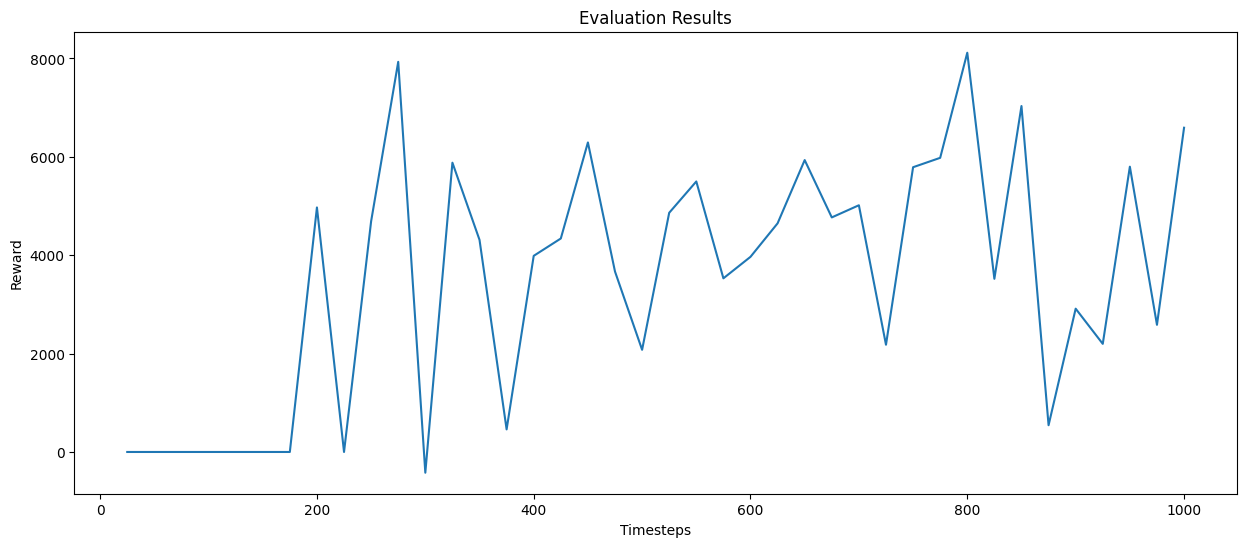

In [ ]:
# plot the training results
timesteps = eval_callback.evaluations_timesteps
rewards = eval_callback.evaluations_results
reward_means = [np.mean(x) for x in rewards]
reward_stds = [np.std(x) for x in rewards]

plt.figure(figsize=(15,6))
plt.errorbar(timesteps, reward_means, yerr=reward_stds)
plt.title('Evaluation Results')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.show()

In [ ]:
# test model
env = gym.make('stocks-v0', df=data, frame_bound=(1000,1200), window_size=10)
obs, info = env.reset()

info {'total_reward': 8642.00390625, 'total_profit': 0.9745641137884646, 'position': <Positions.Long: 1>}


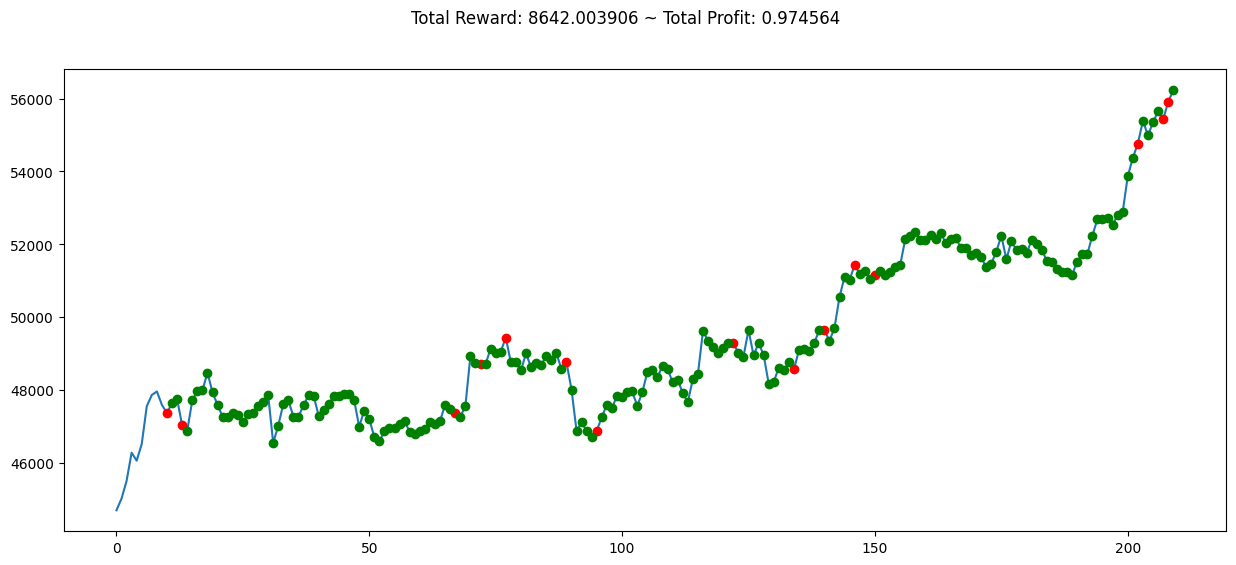

In [ ]:
# load best model
model = DQN.load("logs/best_model.zip")


while True:
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env.step(action)
    if done or truncated:
        print("info", info)
        break

plt.figure(figsize=(15,6), facecolor='white')
plt.cla()
env.unwrapped.render_all()
plt.show()

# Train model for real

In [ ]:
window_size = 60

In [ ]:
# make train and test data
def preprocess_data(data: DataFrame, window_size: int = 60) -> DataFrame:
    """
    Method preprocesses the coin data.
    It normalizes the columns and drops the NaNs.

    Columns 
        * 'Open': divide by 'Close'
        * 'High': divide by 'Close'
        * 'Low': divide by 'Close'
        * 'Close': pct_change()
        * 'Volume': divide by rolling 10-day max

    :param data: DataFrame with coin data
    :param window_size: size of the window
    :return: preprocessed DataFrame
    """
    coin_data_norm = deepcopy(data)
    coin_data_norm['Open'] = coin_data_norm['Open'] / coin_data_norm['Close']
    coin_data_norm['High'] = coin_data_norm['High'] / coin_data_norm['Close']
    coin_data_norm['Low'] = coin_data_norm['Low'] / coin_data_norm['Close']
    coin_data_norm['Close'] = coin_data_norm['Close'].pct_change()

    coin_data_norm['Volume'] = coin_data_norm['Volume'] / coin_data_norm['Volume'].rolling(window_size).max()

    coin_data_norm.dropna(inplace=True)

    return coin_data_norm


def get_train_data(coin_data: DataFrame, window_size: int = 60) -> (DataFrame, DataFrame):
    """
    Method return train and test data from the coin data.
    The test data is a set of 2-month periods taken from each year, selected randomly.
     
    :param coin_data: DataFrame with coin data
    :return: train and test DataFrames
    """
    # normalize the data
    coin_data_norm = preprocess_data(coin_data, window_size=window_size)

    test = pd.DataFrame()
    train = pd.DataFrame()
    for year in coin_data_norm.index.year.unique():
        year_data = coin_data_norm.loc[coin_data_norm.index.year == year]

        # Generate a random start date within the year
        start_day = random.randint(0, len(year_data) - 2 * 24 * 30)
        
        # Select the 2-month period starting from the random start date
        test_data = year_data.iloc[start_day : start_day + 2 * 24 * 30]
        test = pd.concat([test, test_data], ignore_index=True)
        
        # Append the data before and after the test data to the training data
        train_data = pd.concat([year_data.iloc[0 : start_day], year_data.iloc[start_day + 2 * 24 * 30 :]])
        train = pd.concat([train, train_data], ignore_index=True)

    return train, test


In [ ]:
train, test = get_train_data(data, window_size=window_size)
print(train)

# train model
env_maker = lambda: gym.make('stocks-v0', df=train, frame_bound=(window_size,21408), window_size=window_size)
env = DummyVecEnv([env_maker])

model = DQN('MlpPolicy', env, learning_starts=100, verbose=1, tau=0.9, exploration_initial_eps=0.5, exploration_fraction=0.1, exploration_final_eps=0.05)

eval_callback = EvalCallback(
    env, best_model_save_path='./logs/',
    log_path='./logs/', eval_freq=100,
    n_eval_episodes=1,
    deterministic=True, render=False
)
model.learn(total_timesteps=1e4, callback=eval_callback)

           Open      High       Low     Close    Volume
0      0.984437  1.001060  0.981810  0.015809  0.261665
1      1.009084  1.014552  0.994869 -0.009003  0.288960
2      1.006604  1.014906  0.997639 -0.006560  0.277993
3      1.001965  1.010010  0.989307 -0.002021  0.376832
4      1.009100  1.010948  0.976732 -0.009018  0.533344
...         ...       ...       ...       ...       ...
21413  0.996905  1.000049  0.992970  0.003105  0.146617
21414  0.994722  1.003642  0.994339  0.005306  0.251782
21415  0.997131  1.001600  0.993843  0.002877  0.188634
21416  1.005557  1.005591  0.999891 -0.005526  0.135908
21417  1.000591  1.001260  0.999316 -0.000590  0.040107

[21418 rows x 5 columns]
Using cpu device


/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/bitcoinbot/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/bitcoinbot/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100, episode_reward=0.00 +/- 0.00
Episode length: 21347.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.13e+04 |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.455    |
| time/               |          |
|    total_timesteps  | 100      |
----------------------------------
New best mean reward!
Eval num_timesteps=200, episode_reward=0.00 +/- 0.00
Episode length: 21347.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.13e+04 |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.41     |
| time/               |          |
|    total_timesteps  | 200      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000405 |
|    n_updates        | 24       |
----------------------------------
Eval num_timesteps=300, episode_re

/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/bitcoinbot/lib/python3.10/site-packages/gym_anytrading/envs/stocks_env.py:61: RuntimeWarning: invalid value encountered in scalar divide
  shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price


Eval num_timesteps=1500, episode_reward=-1.32 +/- 0.00
Episode length: 21347.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.13e+04 |
|    mean_reward      | -1.32    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 1500     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2e-05  |
|    n_updates        | 349      |
----------------------------------
Eval num_timesteps=1600, episode_reward=0.02 +/- 0.00
Episode length: 21347.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.13e+04 |
|    mean_reward      | 0.02     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss         

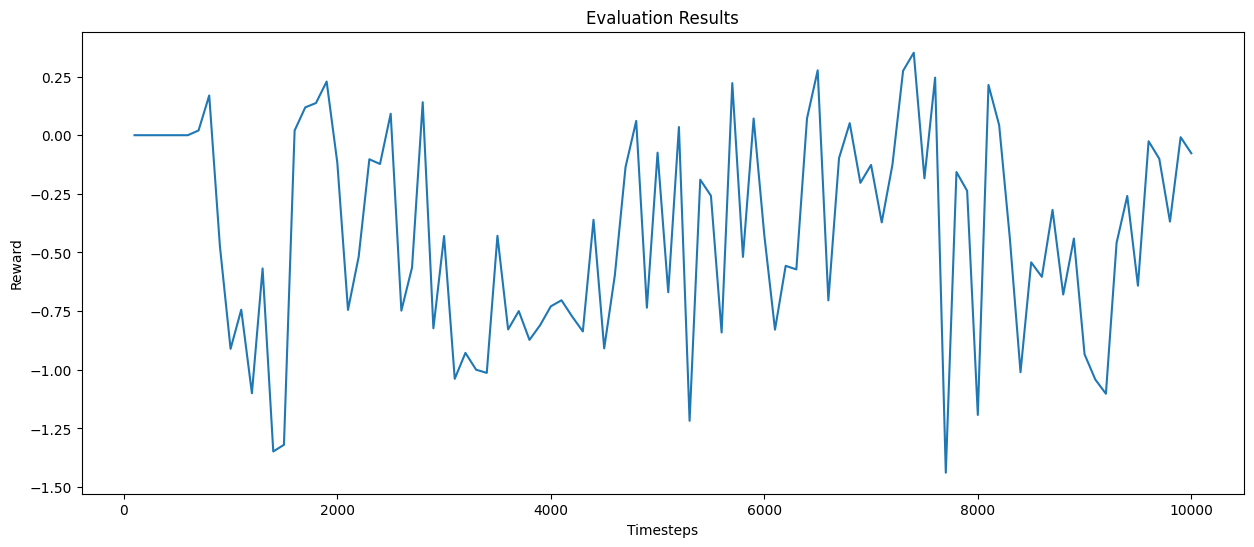

In [ ]:
# plot the training results
timesteps = eval_callback.evaluations_timesteps
rewards = eval_callback.evaluations_results
reward_means = [np.mean(x) for x in rewards]
reward_stds = [np.std(x) for x in rewards]

plt.figure(figsize=(15,6))
plt.errorbar(timesteps, reward_means, yerr=reward_stds)
plt.title('Evaluation Results')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.show()

(4320, 5)
info {'total_reward': -0.10821285199199338, 'total_profit': -8.436956812190325e-12, 'position': <Positions.Long: 1>}


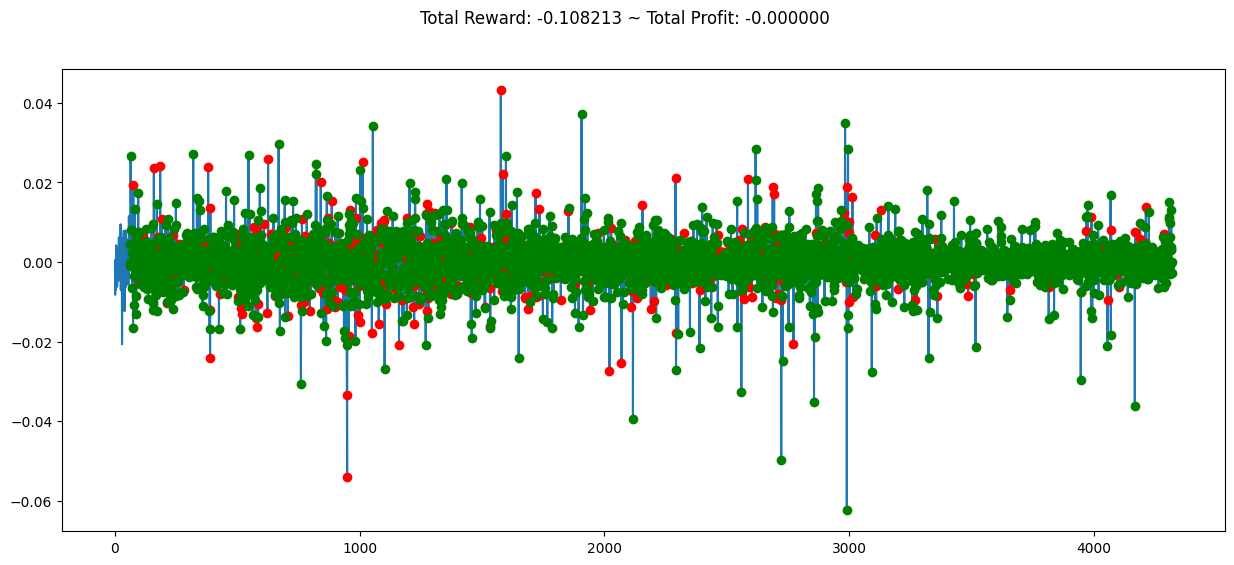

In [ ]:
_, test = get_train_data(data)
print(test.shape)

# test model
env = gym.make('stocks-v0', df=test, frame_bound=(60,4320), window_size=60)
obs, info = env.reset()

# load best model
model = DQN.load("logs/best_model.zip")

while True:
    action, _ = model.predict(obs)
    obs, rewards, done, truncated, info = env.step(action)
    if done or truncated:
        print("info", info)
        break

plt.figure(figsize=(15,6), facecolor='white')
plt.cla()
env.unwrapped.render_all()
plt.show()